In [1]:
# import required libraries
import pandas as pd
import geopandas as gpd
import contextily as ctx
import wget
from pathlib import Path
import fiona
import zipfile
import json
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Load API Key
api_key = "7df38837cf2c0daec8b4eba098c1048ebf441860"
key = f"&key={api_key}"

In [3]:
# build base URL and select dataset
HOST = "http://api.census.gov/data"
dataset = "acs/acs1"

# Select which data tables you want to pull
variables = "NAME,B19013_001E,B25064_001E,B25033_009E,B25033_010E,B25033_011E,B25033_003E,B25033_004E,B25033_005E,B25001_001E,B01003_001E,B25077_001E"
g = "?get="

# change location(s) below
location = "&for=combined%20statistical%20area:*"

# Combine into API url
predicate = f"{g}{variables}{location}"

# print to confirm
display(predicate)

'?get=NAME,B19013_001E,B25064_001E,B25033_009E,B25033_010E,B25033_011E,B25033_003E,B25033_004E,B25033_005E,B25001_001E,B01003_001E,B25077_001E&for=combined%20statistical%20area:*'

In [54]:
# Initialize DataFrame collector and change date range
dfs = []
for year in range (2005, 2010):
    base_url = "/".join([HOST, str(year), dataset])
    r = requests.get(f"{base_url}{g}{variables}{location}{key}")
    df = pd.DataFrame(columns=r.json()[0], data=r.json()[1:])
    # Add column to hold year value
    df["year"] = year
    dfs.append(df)

In [55]:
# Concatenate all DataFrames in collector
us = pd.concat(dfs, ignore_index=True)

In [63]:
# Print sample of DataFrame
us.head()

,NAME,B19013_001E,B25064_001E,B25033_009E,B25033_010E,B25033_011E,B25033_003E,B25033_004E,B25033_005E,B25001_001E,B01003_001E,B25077_001E,combined statistical area,year
0,"Albany-Corvallis-Lebanon, OR CSA",40805,640,26592,12108,17616,103482,698,113,79552,181995,173100,102,2005
1,"Albany-Schenectady-Amsterdam, NY CSA",48609,696,65508,141551,82706,703829,44853,2490,521633,1102287,141900,104,2005
2,"Ames-Boone, IA CSA",41354,648,11984,4401,18743,57242,343,404,45825,96224,136100,112,2005
3,"Appleton-Oshkosh-Neenah, WI CSA",51256,595,24657,22248,34411,268633,4727,1522,157830,362156,136800,118,2005
4,"Asheville-Brevard, NC CSA",38391,608,51287,14907,20004,242912,2352,1327,208949,410029,150400,120,2005


In [51]:
# Reassign column names in the DataFrame
df = us.rename({
    "NAME":"NAMELSAD",
    "B19013_001E":"Med_Inc",
    "B25064_001E":"Med_Rent",
    "B25033_009E":"Renter_1",
    "B25033_010E":"Renter_2_4",
    "B25033_011E":"Renter_5",
    "B25033_003E":"Owner_1",
    "B25033_004E":"Owner_2_4",
    "B25033_005E":"Owner_5",
    "B25010_001E":"Avg_HH_Size",
    "B25010_002E":"Avg_HH_Size_Own",
    "B25010_003E":"Avg_HH_Size_Rent",
    "B25008_002E":"Owner_Occ",
    "B25008_003E":"Renter_Occ",
    "B25004_002E":"Avg_Vac",
    "B25077_001E":"Med_Home_Pr",
    "B25001_001E":"Ttl_Hous_units",
    "B01003_001E":"Ttl_Pop"}, axis=1)

display(df.head())

(625, 14)

In [46]:
# Download Shapefile from census website using wget module
url = "https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_csa_500k.zip"
filename = wget.download(url)

# Unzip the file
with zipfile.ZipFile("cb_2021_us_csa_500k.zip", "r") as zipObj:
    zipObj.extractall()


-1 / unknown

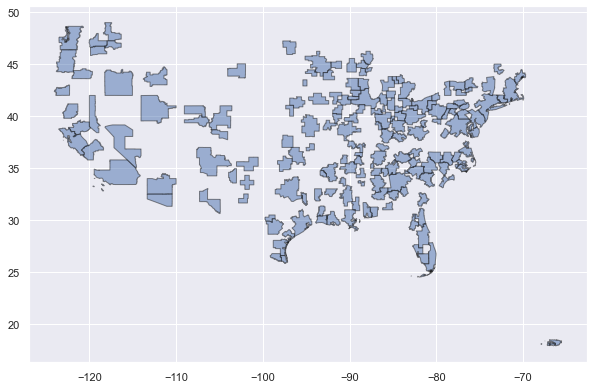

In [75]:
# Create Geopandas GeoDataFrame from shapefile
df_map = gpd.read_file("./cb_2021_us_csa_500k.shp")
ax = df_map.plot(figsize=(10,10), alpha=0.5, edgecolor="k")

In [81]:
df_map.crs
df_wm = df_map.to_crs(epsg=3857)

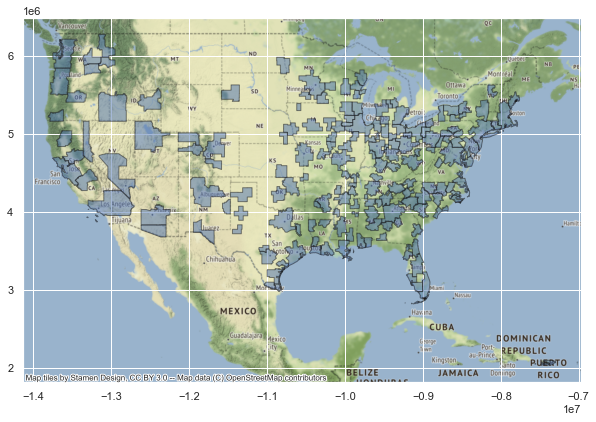

In [82]:
ax = df_wm.plot(figsize=(10,10), alpha=0.5, edgecolor="k")
ctx.add_basemap(ax)

In [83]:
# Merge original DataFrame into GeoDataFrame
merged_df = df_map.merge(df, on="NAME")
merged_df.tail()


,CSAFP,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER,geometry,B19013_001E,...,B25033_010E,B25033_011E,B25033_003E,B25033_004E,B25033_005E,B25001_001E,B01003_001E,B25077_001E,combined statistical area,year


<AxesSubplot:>

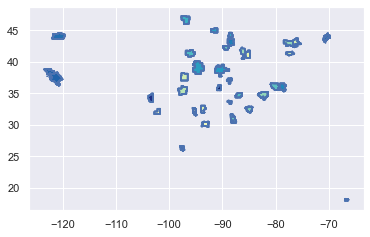

In [71]:
# Heatmap of the areas with greatest rent growth with Geopandas
ax = merged_df.boundary.plot()

merged_df.plot(column="Med_Home_Pr",ax=ax, cmap="YlGnBu")